In [1]:
'''  
@Author: Sharday Olowu
@Date: 03/05/2022

@Sources:
◉ Multivariate time series forecasting - built upon sample of work from: 
https://colab.research.google.com/drive/1b3CUJuDOmPmNdZFH3LQDmt5F0K3FZhqD?usp=sharing
Work author: Greg Hogg 

Modifications:
- extended to allow user to change forecast length via ADVANCE_STEPS
- visualisation of simulation output file network measurements and handovers
- pre-processing steps to combine all simulation output into one dataframe, recording file positions within dataframe
- pre-processing steps to mitigate simulation artefacts in 4-cell network simulations
- alteration of pre-processing and training steps from 2-cell scenario to accommodate more output variables (RSRP values for 4 cells)
- forming windows and labels from individual time series within large dataframe
- altered LSTM model architecture for required dimensions for multi-variate time series forecasting
- altered LSTM model architecture to include dropout layer to minimise overfitting in this more complex scenario
- scaled data via StandardScaler function from sklearn
- automatic train/validation/test split of 80/10/10 with any dataset
- extension of plot_predictions to rescale and visualise RSRP-1, RSRP-2, RSRP-3 and RSRP-4
- calculation of RMSE and MAE on the test set

◉ Learned how to train an XGBoost model for classification and calculate performance metrics during online course - Machine Learning A-Z (Udemy):
https://www.udemy.com/course/machinelearning/learn/lecture/6087180#overview

◉ Hyperparameter grid search - adapted from:
https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook
Work author: 'Tilii: https://kaggle.com/tilii7' 

Modifications:
- increaed number of stratified folds to increase reliablility
- modified to work with the current data
- objective function changed to 'multi:softprob' for multi-class classification due to 4-cell network scenario
- code simplification

◉ ROC curve and AUC calculation - adapted from:
https://python-bloggers.com/2020/12/roc-and-auc-how-to-evaluate-machine-learning-models-in-no-time/
Work author: Dario Radečić 

Modifications: 
- pre-processing of current data 
- modified for multi-class classification using one-vs-rest approach - one ROC curve for each class
- code simplification
- improved ROC graph visualisation


'''

"  \n@Author: Sharday Olowu\n@Date: 03/05/2022\n\n@Sources:\n◉ Multivariate time series forecasting - built upon sample of work from: \nhttps://colab.research.google.com/drive/1b3CUJuDOmPmNdZFH3LQDmt5F0K3FZhqD?usp=sharing\nWork author: Greg Hogg \n\nModifications:\n-extended to allow user to change forecast length via ADVANCE_STEPS\n-visualisation of simulation output file network measurements and handovers\n-pre-processing steps to combine all simulation output into one dataframe, recording file positions within dataframe\n-pre-processing steps to mitigate simulation artefacts in 4-cell network simulations\n-alteration of pre-processing and training steps from 2-cell scenario to accommodate more output variables (RSRP values for 4 cells)\n-forming windows and labels from individual time series within large dataframe\n-altered LSTM model architecture for required dimensions for multi-variate time series forecasting\n-altered LSTM model architecture to include dropout layer to minimise 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
plt.rcParams.update({'font.size': 22})

In [3]:
#set random seed for reproducible results
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# View a simulation output file

In [4]:
df = pd.read_csv('C:/Users/shard/Documents/workspace/sim_outputs_4_cells/13.txt') # example simulation output file

# ensure RSRP and RSRQ values are negative
df["RSRP_eNB_1"] = -df["RSRP_eNB_1"] 
df["RSRP_eNB_2"] = -df["RSRP_eNB_2"] 
df["RSRP_eNB_3"] = -df["RSRP_eNB_3"] 
df["RSRP_eNB_4"] = -df["RSRP_eNB_4"] 

df["RSRQ_eNB_1"] = -df["RSRQ_eNB_1"] 
df["RSRQ_eNB_2"] = -df["RSRQ_eNB_2"] 
df["RSRQ_eNB_3"] = -df["RSRQ_eNB_3"] 
df["RSRQ_eNB_4"] = -df["RSRQ_eNB_4"] 
df

,time,x,y,RSRP_eNB_1,RSRP_eNB_2,RSRP_eNB_3,RSRP_eNB_4,RSRQ_eNB_1,RSRQ_eNB_2,RSRQ_eNB_3,RSRQ_eNB_4,S-PCI,Unnamed: 12
0,0.680001,735.44,278.84,-79,-94,-83,-81,-2,-32,-9,-6,1,NaN
1,1.160000,731.56,276.70,-81,-88,-86,-81,-12,-26,-21,-13,1,NaN
2,1.224000,731.56,276.70,-81,-87,-86,0,-14,-25,-24,0,1,NaN
3,1.400000,731.56,276.70,-82,-86,-87,-81,-15,-24,-25,-14,2,NaN
4,1.880000,731.56,276.70,-82,-86,-87,-81,-16,-24,-26,-15,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,997.640000,847.68,247.14,-77,-88,-78,-82,-8,-30,-10,-18,2,NaN
2152,998.120000,844.66,254.14,-77,-88,-78,-83,-8,-29,-10,-20,2,NaN
2153,998.600000,824.10,225.94,-78,-86,-78,-85,-10,-27,-10,-24,2,NaN
2154,999.080000,878.86,225.98,-78,-83,-77,-87,-11,-22,-9,-28,2,NaN


## Network measurement variations - simulation artefacts

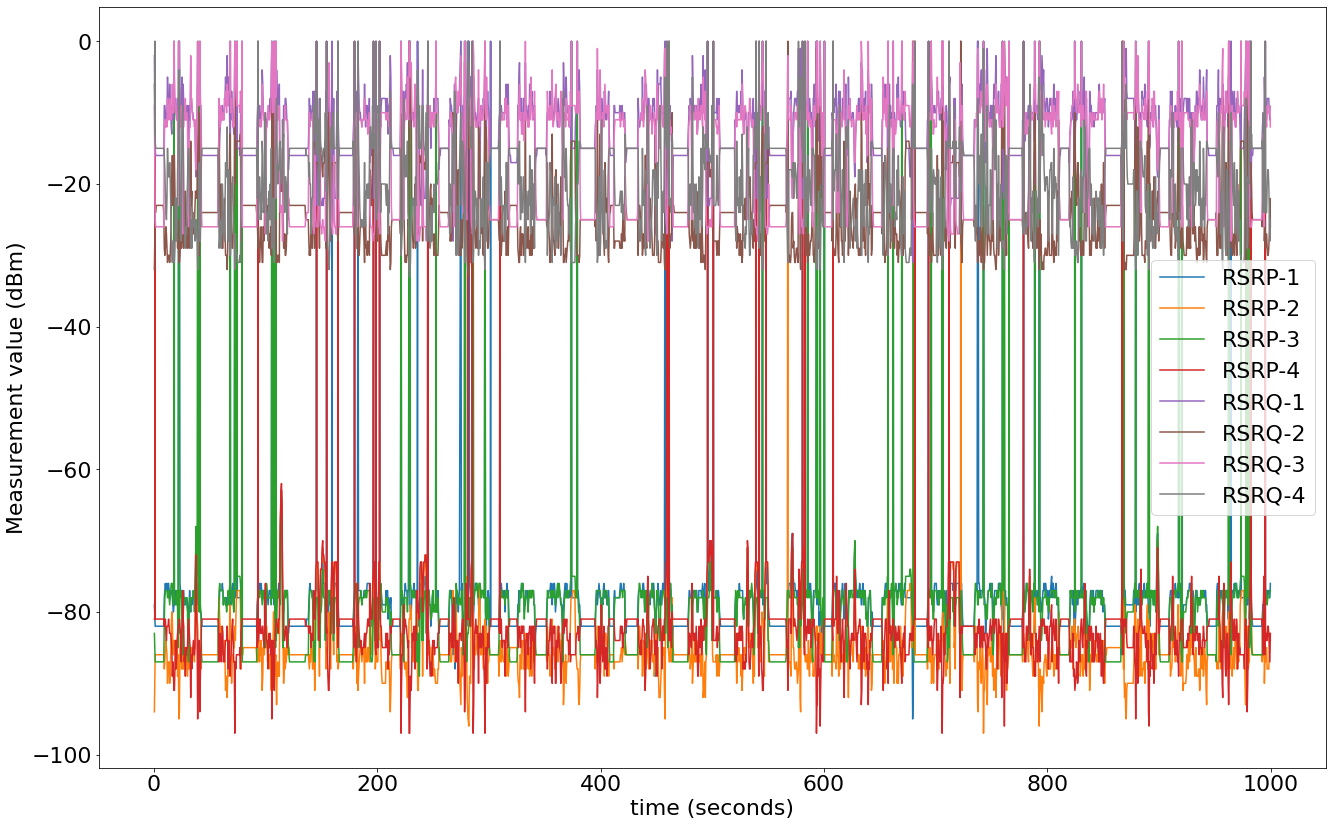

In [5]:
plt.rcParams["figure.figsize"] = (22, 14)
RSRP1 = df.iloc[:,3].values
RSRP2 = df.iloc[:,4].values
RSRP3 = df.iloc[:,5].values
RSRP4 = df.iloc[:,6].values

RSRQ1 = df.iloc[:,7].values
RSRQ2 = df.iloc[:,8].values
RSRQ3 = df.iloc[:,9].values
RSRQ4 = df.iloc[:,10].values
time = df.iloc[:,0].values
S_PCI = df.iloc[:,11].values

plt.plot(time, RSRP1, label='RSRP-1')
plt.plot(time, RSRP2, label='RSRP-2')
plt.plot(time, RSRP3, label='RSRP-3')
plt.plot(time, RSRP4, label='RSRP-4')

plt.plot(time, RSRQ1, label='RSRQ-1')
plt.plot(time, RSRQ2, label='RSRQ-2')
plt.plot(time, RSRQ3, label='RSRQ-3')
plt.plot(time, RSRQ4, label='RSRQ-4')

plt.xlabel('time (seconds)')
plt.ylabel('Measurement value (dBm)')
plt.legend(loc='center right')
plt.show()

## Network measurement variations - artefacts mitigated

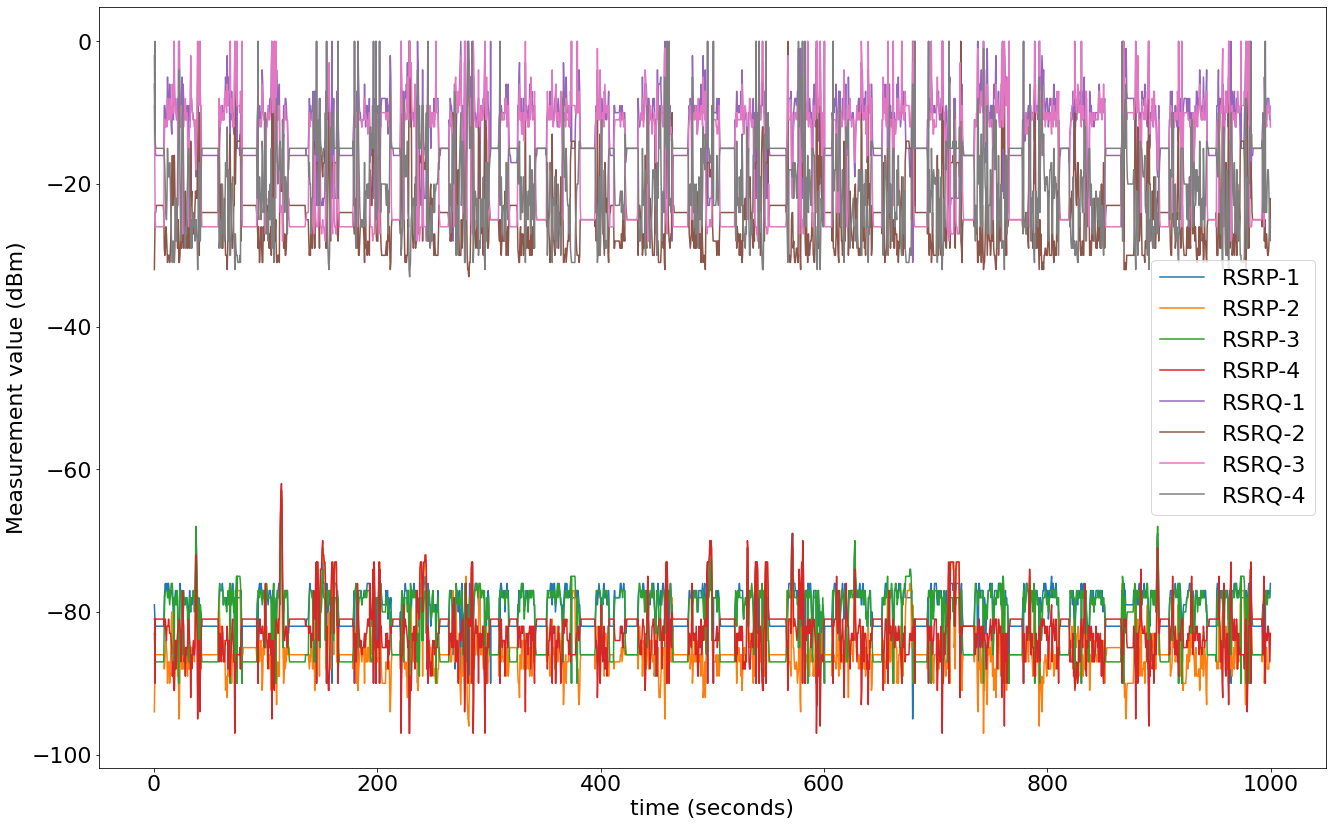

In [6]:
df2 = df.copy()

# mitigation of simualtion artefacts
df2.RSRP_eNB_1 = np.where((df2.RSRP_eNB_1 > -60), -90, df2.RSRP_eNB_1)
df2.RSRP_eNB_2 = np.where((df2.RSRP_eNB_2 > -60), -90, df2.RSRP_eNB_2)
df2.RSRP_eNB_3 = np.where((df2.RSRP_eNB_3 > -60), -90, df2.RSRP_eNB_3)
df2.RSRP_eNB_4 = np.where((df2.RSRP_eNB_4 > -60), -90, df2.RSRP_eNB_4)


RSRP1 = df2.iloc[:,3].values
RSRP2 = df2.iloc[:,4].values
RSRP3 = df2.iloc[:,5].values
RSRP4 = df2.iloc[:,6].values

RSRQ1 = df2.iloc[:,7].values
RSRQ2 = df2.iloc[:,8].values
RSRQ3 = df2.iloc[:,9].values
RSRQ4 = df2.iloc[:,10].values
time = df2.iloc[:,0].values
S_PCI = df2.iloc[:,11].values


plt.plot(time, RSRP1, label='RSRP-1')
plt.plot(time, RSRP2, label='RSRP-2')
plt.plot(time, RSRP3, label='RSRP-3')
plt.plot(time, RSRP4, label='RSRP-4')

plt.plot(time, RSRQ1, label='RSRQ-1')
plt.plot(time, RSRQ2, label='RSRQ-2')
plt.plot(time, RSRQ3, label='RSRQ-3')
plt.plot(time, RSRQ4, label='RSRQ-4')

plt.xlabel('time (seconds)')
plt.ylabel('Measurement value (dBm)')
plt.legend(loc='center right')


plt.show()

## Handovers

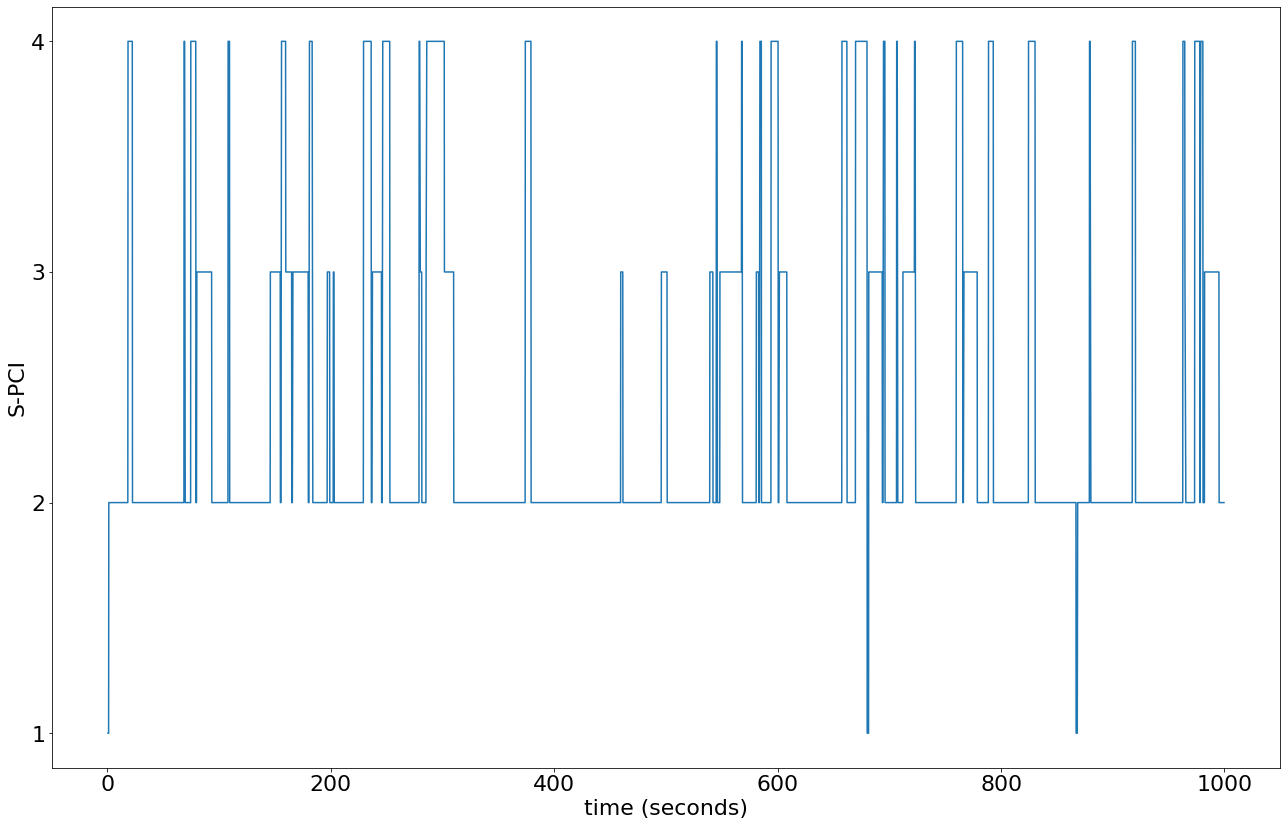

In [7]:
plt.xlabel('time (seconds)')
plt.ylabel('S-PCI')
plt.yticks(np.arange(5))
plt.plot(time, S_PCI, label='S_PCI')
plt.show()

# LSTM - multivariate time series forecasting

## Data pre-processing

In [8]:

def df_to_X_y(df, advance, window_size):
  X = []
  y = []
  for i in range(len(df)-window_size-advance):
    row = [r for r in df[i:i+window_size]]
    X.append(row)
    label = [df[i+window_size+advance][0], df[i+window_size+advance][1], df[i+window_size+advance][2], df[i+window_size+advance][3]]
    y.append(label)
  return np.array(X), np.array(y)

In [9]:
WINDOW_SIZE = 5
ADVANCE_STEPS = 1 #can be adjusted to change forecast length


dfs = []

fileEndPoints = []

#read 100 simulation output files
for i in range(100):
    
    dfc = pd.read_csv('C:/Users/shard/Documents/workspace/sim_outputs_4_cells/spaced/' + str(i) + '.txt')
    
    # values should be negative
    dfc["RSRP_eNB_1"] = -dfc["RSRP_eNB_1"] 
    dfc["RSRP_eNB_2"] = -dfc["RSRP_eNB_2"] 
    dfc["RSRP_eNB_3"] = -dfc["RSRP_eNB_3"] 
    dfc["RSRP_eNB_4"] = -dfc["RSRP_eNB_4"] 

    dfc["RSRQ_eNB_1"] = -dfc["RSRQ_eNB_1"] 
    dfc["RSRQ_eNB_2"] = -dfc["RSRQ_eNB_2"] 
    dfc["RSRQ_eNB_3"] = -dfc["RSRQ_eNB_3"] 
    dfc["RSRQ_eNB_4"] = -dfc["RSRQ_eNB_4"] 
    
    # mitigate simulation artefacts
    dfc.RSRP_eNB_1 = np.where((dfc.RSRP_eNB_1 > -60), -90, dfc.RSRP_eNB_1)
    dfc.RSRP_eNB_2 = np.where((dfc.RSRP_eNB_2 > -60), -90, dfc.RSRP_eNB_2)
    dfc.RSRP_eNB_3 = np.where((dfc.RSRP_eNB_3 > -60), -90, dfc.RSRP_eNB_3)
    dfc.RSRP_eNB_4 = np.where((dfc.RSRP_eNB_4 > -60), -90, dfc.RSRP_eNB_4)
    
    # record positions of files
    if len(fileEndPoints) > 0:
        lastStart = fileEndPoints[-1]
    else:
        lastStart = 0
    
    fileEndPoints.append(lastStart + len(dfc))
    
    # select relevant columns
    
    cols = list(dfc)[3:12]
    train_df = dfc[cols]
    dfs.append(train_df)
    
    

#concatenate all dataframes into one large dataframe containing all simulation output
frame = pd.concat(dfs, axis=0, ignore_index=True)


SPCI_labels = frame.iloc[:,-1].values
frame = frame.iloc[:,:-1].astype(float)

frame

,RSRP_eNB_1,RSRP_eNB_2,RSRP_eNB_3,RSRP_eNB_4,RSRQ_eNB_1,RSRQ_eNB_2,RSRQ_eNB_3,RSRQ_eNB_4
0,-82.0,-78.0,-78.0,-83.0,-23.0,-15.0,-17.0,-26.0
1,-82.0,-82.0,-81.0,-91.0,-12.0,-12.0,-10.0,-30.0
2,-84.0,-83.0,-83.0,-90.0,-16.0,-14.0,-14.0,-29.0
3,-84.0,-90.0,-90.0,-89.0,-17.0,0.0,0.0,-29.0
4,-84.0,-81.0,-81.0,-88.0,-20.0,-14.0,-15.0,-28.0
...,...,...,...,...,...,...,...,...
202900,-84.0,-81.0,-90.0,-82.0,-17.0,-12.0,-30.0,-12.0
202901,-93.0,-80.0,-87.0,-81.0,-27.0,0.0,-15.0,-4.0
202902,-90.0,-81.0,-88.0,-83.0,-27.0,-8.0,-23.0,-13.0
202903,-89.0,-79.0,-91.0,-81.0,-24.0,-5.0,-28.0,-7.0


In [10]:
#scale data

scaler = StandardScaler()
scaler = scaler.fit(frame)
train_df_scaled = scaler.transform(frame)
train_df_scaled

array([[ 0.03297072,  0.68234641,  0.92637072, ..., -0.02915456,
         0.11998257, -0.81223486],
       [ 0.03297072, -0.02176927,  0.40045993, ...,  0.34948467,
         0.85236319, -1.26195298],
       [-0.36064686, -0.19779819,  0.04985273, ...,  0.09705851,
         0.43385998, -1.14952345],
       ...,
       [-1.54149963,  0.15425965, -0.82666526, ...,  0.85433698,
        -0.50777224,  0.64934904],
       [-1.34469083,  0.50631749, -1.35257605, ...,  1.23297621,
        -1.03090125,  1.32392623],
       [-1.34469083,  0.50631749, -1.52787965, ...,  1.35918929,
        -1.13552706,  1.43635576]])

In [11]:
numFiles = 10
startPoint = 0

X2, y2 = np.empty((0, 5, 8)), np.empty((0, 4))
totalWindows = 0

#convert simulation output into windows and labels

for i in range(len(fileEndPoints)):

    current_df = train_df_scaled[startPoint:fileEndPoints[i]]
    
    X, y = df_to_X_y(current_df, ADVANCE_STEPS-1, WINDOW_SIZE)

    numWindows = len(y)
    if numWindows < 1:
        continue
    totalWindows += numWindows

    X2 = np.concatenate((X2,X), axis=0)
    y2 = np.concatenate((y2,y), axis=0)
    startPoint += fileEndPoints[i] - startPoint
    

X2.shape, y2.shape


((202405, 5, 8), (202405, 4))

In [12]:

import math

# split into training, validation and testing sets

endTrain = math.floor(0.8 * X2.shape[0])
endVal = math.floor(0.9 * X2.shape[0])

X2_train, y2_train = X2[:endTrain], y2[:endTrain]
X2_val, y2_val = X2[endTrain:endVal], y2[endTrain:endVal]
X2_test, y2_test = X2[endVal:], y2[endVal:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((161924, 5, 8),
 (161924, 4),
 (20240, 5, 8),
 (20240, 4),
 (20241, 5, 8),
 (20241, 4))

## Training - RSRP-1, RSRP-2, RSRP-3 and RSRP-4 forecasting

In [13]:
def build_model():
    model = Sequential()
    model.add(InputLayer((5, 8)))
    model.add(LSTM(64))
    model.add(Dropout(0.1))
    model.add(Dense(8, 'relu'))
    model.add(Dense(4, 'linear'))

    return model

In [14]:
model4 = build_model()
model4.summary()
cp2 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                18688     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
Total params: 19,244
Trainable params: 19,244
Non-trainable params: 0
_________________________________________________________________


In [15]:
history4 = model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp2])

Epoch 1/50
5048/5061 [============================>.] - ETA: 0s - loss: 0.4442 - root_mean_squared_error: 0.6665WARNING:tensorflow:From C:\Users\shard\anaconda3\envs\irp\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model4\assets
5061/5061 [==============================] - 11s 2ms/step - loss: 0.4440 - root_mean_squared_error: 0.6663 - val_loss: 0.4102 - val_root_mean_squared_error: 0.6405
Epoch 2/50
5061/5061 [==============================] - 11s 2ms/step - loss: 0.3465 - root_mean_squared_error: 0.5886 - val_loss: 0.3846 - val_root_mean_squared_error: 0.6202
Epoch 3/50
5061

5061/5061 [==============================] - 8s 1ms/step - loss: 0.2979 - root_mean_squared_error: 0.5458 - val_loss: 0.3438 - val_root_mean_squared_error: 0.5864
Epoch 28/50
5061/5061 [==============================] - 12s 2ms/step - loss: 0.2975 - root_mean_squared_error: 0.5455 - val_loss: 0.3405 - val_root_mean_squared_error: 0.5835
Epoch 29/50
5061/5061 [==============================] - 8s 2ms/step - loss: 0.2968 - root_mean_squared_error: 0.5448 - val_loss: 0.3435 - val_root_mean_squared_error: 0.5861
Epoch 30/50
5061/5061 [==============================] - 7s 1ms/step - loss: 0.2962 - root_mean_squared_error: 0.5442 - val_loss: 0.3417 - val_root_mean_squared_error: 0.5846
Epoch 31/50
5061/5061 [==============================] - 13s 3ms/step - loss: 0.2956 - root_mean_squared_error: 0.5437 - val_loss: 0.3405 - val_root_mean_squared_error: 0.5835
Epoch 32/50
5061/5061 [==============================] - 7s 1ms/step - loss: 0.2953 - root_mean_squared_error: 0.5434 - val_loss: 0.340

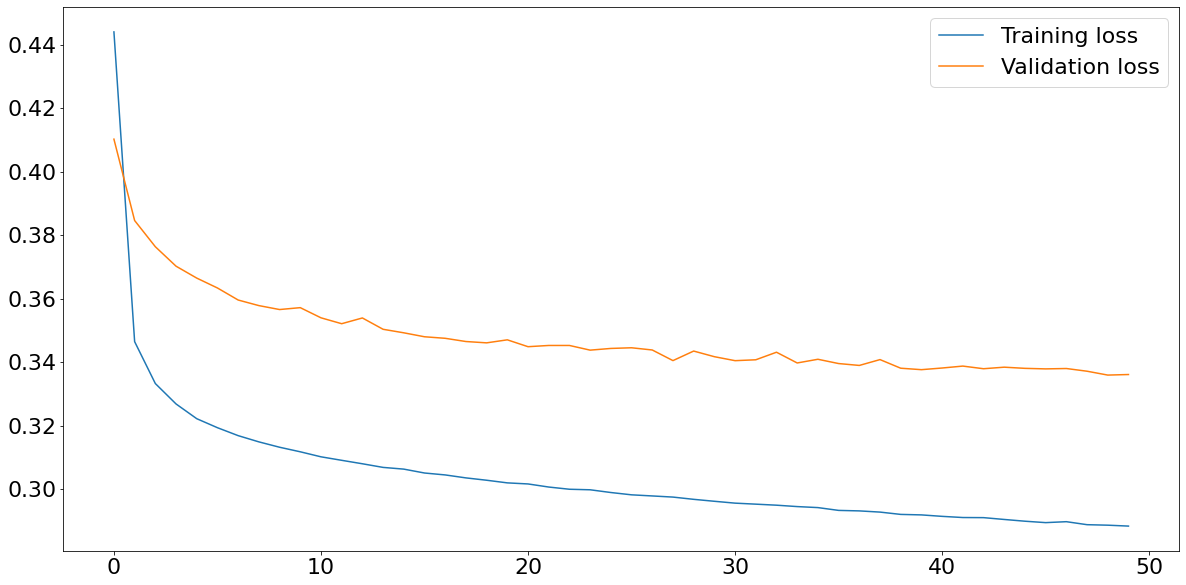

In [16]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

## Visualisation of test set sample

In [17]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import math

def plot_predictions(model, X, y, start=0, end=500, num_features=4):
  
  expanded_preds = np.repeat(model.predict(X), 2, axis=1)
  print(expanded_preds.shape)
  predictions = scaler.inverse_transform(expanded_preds)
  rsrp1_preds, rsrp2_preds, rsrp3_preds, rsrp4_preds = predictions[:,0], predictions[:,1], predictions[:,2], predictions[:,3]
  actuals = scaler.inverse_transform(np.repeat(y, 2, axis=1))
  rsrp1_actuals, rsrp2_actuals, rsrp3_actuals, rsrp4_actuals = actuals[:, 0], actuals[:, 1], actuals[:, 2], actuals[:, 3]
  df = pd.DataFrame(data={'RSRP-1 Predictions': rsrp1_preds,
                          'RSRP-1 Actuals':rsrp1_actuals,
                          'RSRP-2 Predictions': rsrp2_preds,
                          'RSRP-2 Actuals': rsrp2_actuals
                          })
  plt.plot(df['RSRP-1 Predictions'][start:end], label='RSRP-1 Predictions')
  plt.plot(df['RSRP-1 Actuals'][start:end], label='RSRP-1 Actuals')
#   plt.plot(df['RSRP-2 Predictions'][start:end], label='RSRP-2 Predictions')
#   plt.plot(df['RSRP-2 Actuals'][start:end], label='RSRP-2 Actuals') 
  plt.legend()
  plt.xlabel('time (seconds)')
  plt.ylabel('RSRP (dBm)')
  return math.sqrt(mse(rsrp1_actuals, rsrp1_preds)),  math.sqrt(mse(rsrp2_actuals, rsrp2_preds)), math.sqrt(mse(rsrp3_actuals, rsrp3_preds)),  math.sqrt(mse(rsrp4_actuals, rsrp4_preds)), math.sqrt(mae(rsrp1_actuals, rsrp1_preds)),  math.sqrt(mae(rsrp2_actuals, rsrp2_preds)), math.sqrt(mae(rsrp3_actuals, rsrp3_preds)),  math.sqrt(mae(rsrp4_actuals, rsrp4_preds))
  

(20241, 8)


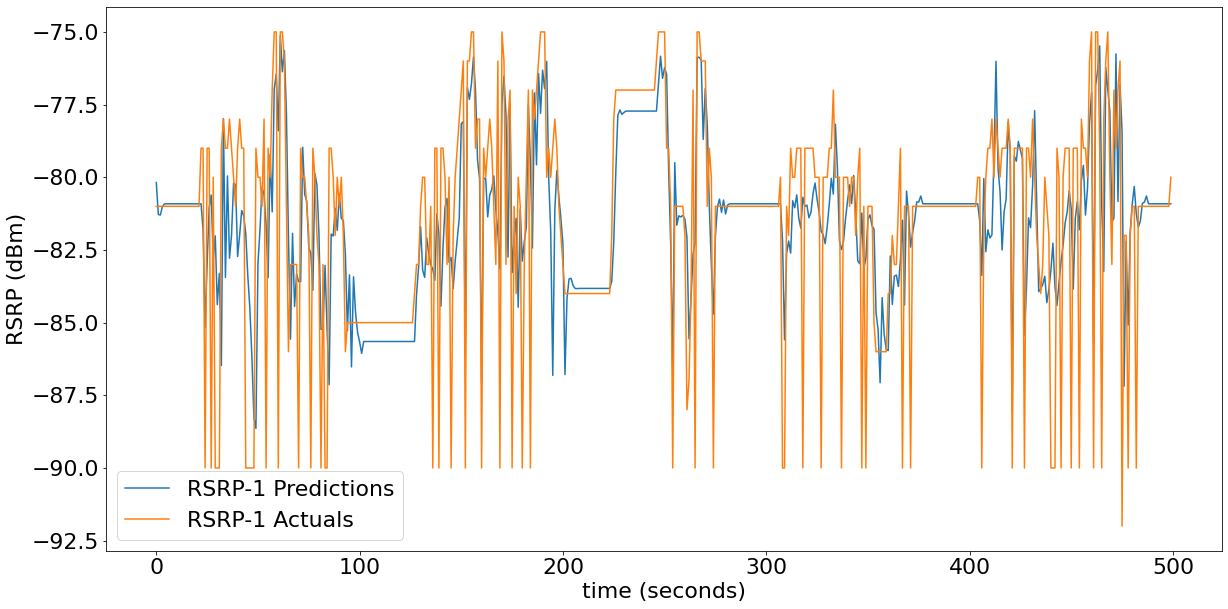

In [18]:
rmse1, rmse2, rmse3, rmse4, mae1, mae2, mae3, mae4 = plot_predictions(model4, X2_test, y2_test)


RMSE = (rmse1 + rmse2 + rmse3 + rmse4) / 4
MAE = (mae1 + mae2 + mae3 + mae4) / 4


In [19]:
# model4.save("model4.h5")

# XGBoost - S-PCI multi-class classification

In [20]:
expanded_preds = np.repeat(model4.predict(X2_test), 2, axis=1)
forecasted_predictions = scaler.inverse_transform(expanded_preds)
forecasted_predictions.shape


(20241, 8)

In [21]:
S_PCI_actual = SPCI_labels[-forecasted_predictions.shape[0]:]
S_PCI_actual.shape

(20241,)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(forecasted_predictions, S_PCI_actual, test_size = 0.25, random_state = 0)

In [23]:
from sklearn.preprocessing import StandardScaler
sc_class = StandardScaler()
X_train = sc_class.fit_transform(X_train)
X_test = sc_class.transform(X_test)

In [24]:
from xgboost import XGBClassifier
classifier = XGBClassifier(random_state = 0)
classifier.fit(X_train, y_train)
probs_xg_default = classifier.predict_proba(X_test)[:, 1]


C:\Users\shard\anaconda3\envs\irp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\shard\anaconda3\envs\irp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:11:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
pre_acc = accuracy_score(y_test, y_pred)


[[ 388   17  376   66]
 [   5  289  234  130]
 [ 261  170 1744  207]
 [  57   93  282  742]]


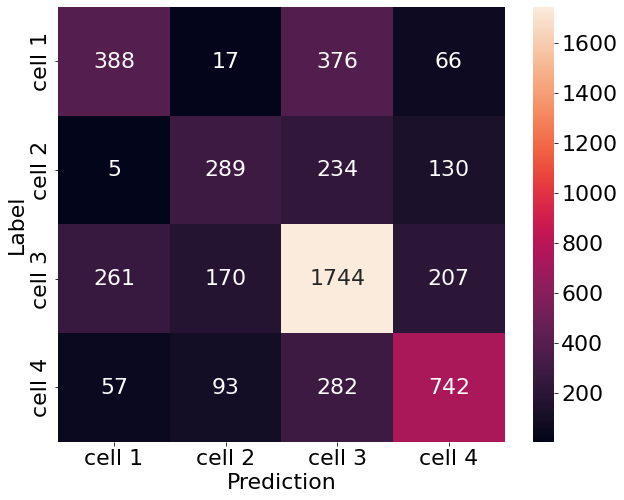

In [26]:
labels = ['cell 1','cell 2','cell 3','cell 4']

# confusion_mtx = tf.math.confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Hyperparameter tuning via randomised grid search

In [27]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


In [28]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softprob', silent=True, nthread=1)

In [29]:
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 7)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=7 )

random_search.fit(X_train, y_train)

print('\n Best hyperparameters:')
print(random_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\shard\anaconda3\envs\irp\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\shard\anaconda3\envs\irp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:47] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:13:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 2, 'colsample_bytree': 0.8}


## Training with tuned hyperparameters

In [30]:
classifier2 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1, subsample = 0.6, min_child_weight = 5, max_depth = 4, gamma = 2, colsample_bytree = 0.8, random_state=0)
classifier2.fit(X_train, y_train)
probs_xg = classifier2.predict_proba(X_test)

[20:14:03] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:14:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Performance evaluation

### Accuracy, confusion matrix, F1-score

In [31]:
y_pred = classifier2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

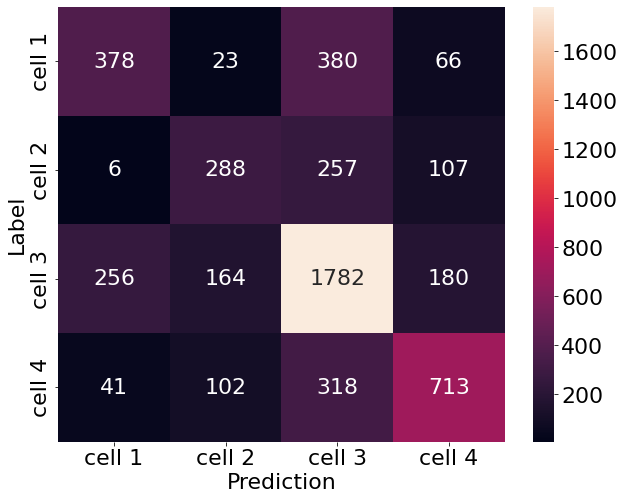

In [32]:
labels = ['cell 1','cell 2','cell 3','cell 4']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### ROC curve and AUC

In [33]:
y_test[y_test==1] = 0
y_test[y_test==2] = 1
y_test[y_test==3] = 2
y_test[y_test==4] = 3
y_test

array([3, 2, 3, ..., 3, 0, 2], dtype=int64)

In [34]:
y_test

array([3, 2, 3, ..., 3, 0, 2], dtype=int64)

In [35]:
# AUC score

AUC_score = roc_auc_score(y_test, probs_xg, multi_class='ovr')
print("AUC score (OVR):")
print(AUC_score)


AUC score (OVR):
0.8474168146244421


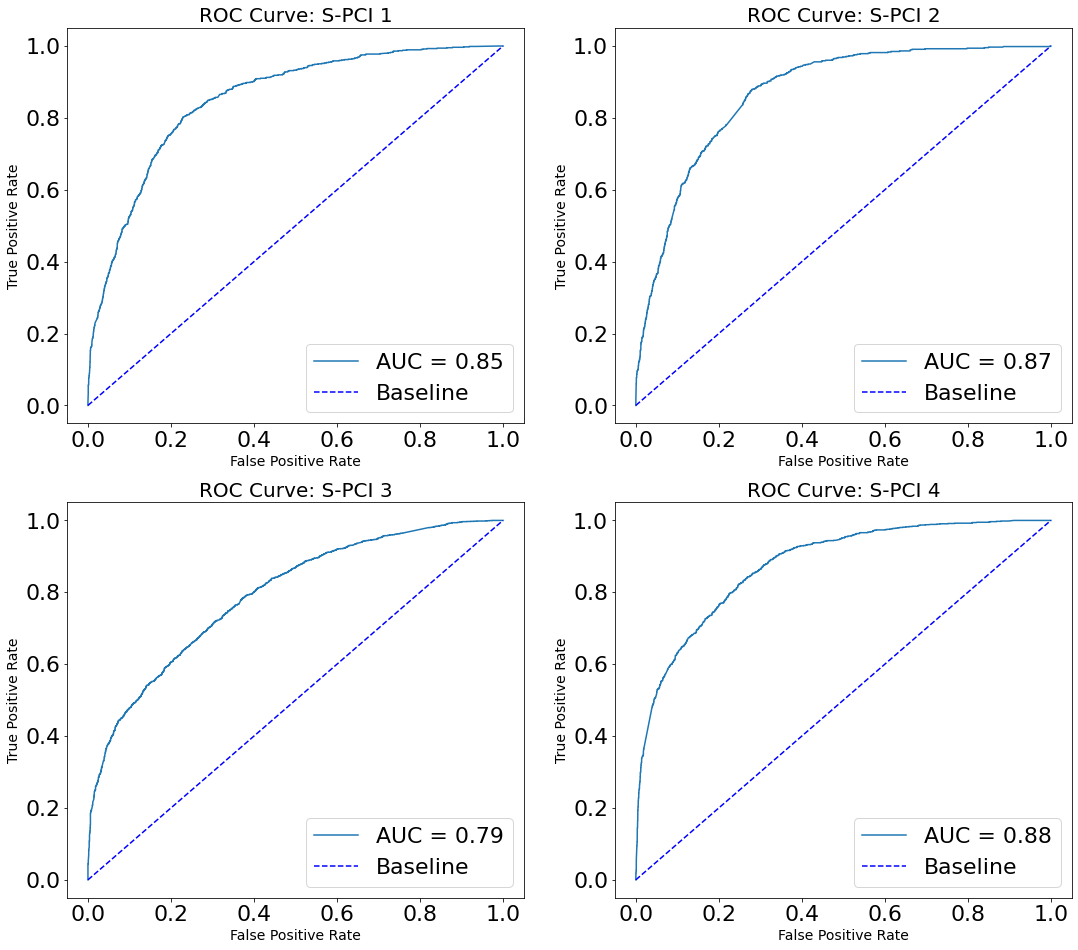

In [36]:
from sklearn.metrics import roc_curve

num_classes = 4

plt.figure(figsize = (18, 16))

for i in range(num_classes):
    ax = plt.subplot(2, 2, i+1)
    
    y_test_copy = np.copy(y_test)
    y_test_copy[y_test_copy!=i] = -1
    y_test_copy[y_test_copy==i] = 1
    y_test_copy[y_test_copy==-1] = 0
    
    auc_xg = roc_auc_score(y_test_copy, probs_xg[:,i])
    fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test_copy, probs_xg[:,i])

    ax.plot(fpr_xg, tpr_xg, label=f'AUC = {auc_xg:.2f}')
    ax.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
    ax.set_title('ROC Curve: S-PCI '+str(i+1), size=20)
    ax.set_xlabel('False Positive Rate', size=14)
    ax.set_ylabel('True Positive Rate', size=14)
    ax.legend(loc="lower right");

In [37]:
#print results

print("RMSE:",RMSE)
print("MAE:",MAE)
print("Accuracy:",acc)
print("F1-score:",f1)
print("AUC:",AUC_score)


RMSE: 3.511569775350921
MAE: 1.5293612710035154
Accuracy: 0.6245801225054337
F1-score: 0.6188007354417644
AUC: 0.8474168146244421
